- run parametric tsne
- compute metrics (training and test data)
    - silhouette
    - knn
    - trustworthiness

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
dataset = 'mnist'
dims = (28,28,1)

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [8]:
dims = (28,28,1)
n_components = 2

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [10]:
batch_size = 5000

In [11]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [12]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [50]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

Precomputing P-values...


Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.210395926597027
Minimum value of sigma: 1.1465189822400297
Maximum value of sigma: 3.423562241637291
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/parametric_tsne/mnist/P.npy'

In [14]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [15]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [16]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [17]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [18]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0719 23:47:11.793876 139813086885696 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples
Epoch 1/1000
50000/50000 [==============================] - 10s 204us/sample - loss: 3.7746
Epoch 2/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 3.1150
Epoch 3/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.8069
Epoch 4/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.6151
Epoch 5/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.5144
Epoch 6/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.4141
Epoch 7/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.3502
Epoch 8/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 2.3006
Epoch 9/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.2750
Epoch 10/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.2421
Epoch 11/1000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.6588
Epoch 180/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.6535
Epoch 181/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6418
Epoch 182/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6315
Epoch 183/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.6306
Epoch 184/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6393
Epoch 185/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.6505
Epoch 186/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6483
Epoch 187/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.6398
Epoch 188/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.6372
Epoch 189/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.6362
Epo

50000/50000 [==============================] - 1s 17us/sample - loss: 1.5412
Epoch 358/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5445
Epoch 359/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5449
Epoch 360/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5440
Epoch 361/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5427
Epoch 362/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5483
Epoch 363/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5503
Epoch 364/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5553
Epoch 365/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5591
Epoch 366/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5581
Epoch 367/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5548
Epo

50000/50000 [==============================] - 1s 17us/sample - loss: 1.5202
Epoch 536/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5210
Epoch 537/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5161
Epoch 538/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5064
Epoch 539/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.5022
Epoch 540/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4957
Epoch 541/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4952
Epoch 542/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4956
Epoch 543/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4991
Epoch 544/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5056
Epoch 545/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4978
Epo

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4834
Epoch 714/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4836
Epoch 715/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4830
Epoch 716/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4800
Epoch 717/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4781
Epoch 718/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4762
Epoch 719/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4810
Epoch 720/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4854
Epoch 721/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4887
Epoch 722/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4868
Epoch 723/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4868
Epo

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4665
Epoch 892/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4632
Epoch 893/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4656
Epoch 894/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4665
Epoch 895/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4660
Epoch 896/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4694
Epoch 897/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4678
Epoch 898/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4611
Epoch 899/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4621
Epoch 900/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4628
Epoch 901/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4637
Epo

### get z for training and test

In [19]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

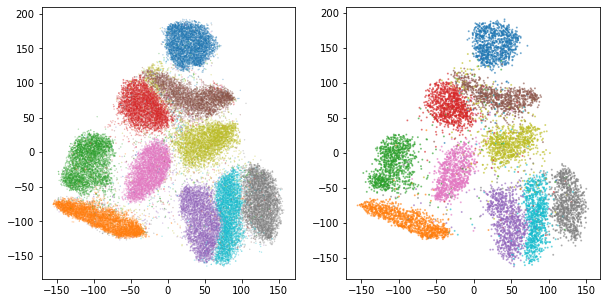

In [20]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train, cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [21]:
import os

In [22]:
output_dir = MODEL_DIR/'projections'/ dataset / 'parametric-tsne'

In [23]:
encoder.save(os.path.join(output_dir, "encoder"))

W0720 00:01:36.685059 139813086885696 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0720 00:01:36.938497 139813086885696 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/parametric-tsne/encoder/assets


In [24]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [25]:
from tfumap.silhouette import silhouette_score_block

In [26]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.37101547365399584

In [27]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.3850023246780673

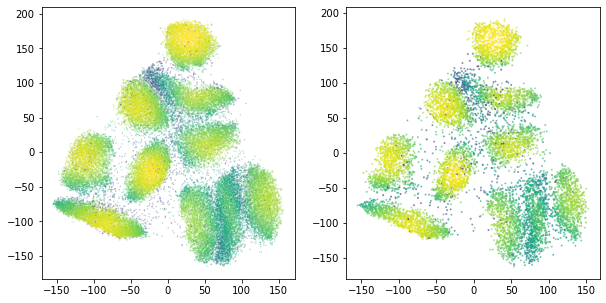

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9378

In [31]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9118

#### Trustworthiness

In [32]:
from sklearn.manifold import trustworthiness

In [33]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [36]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [37]:
tw, tw_test

(0.9654839551641313, 0.9260239011208967)

#### save output metrics

In [44]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,mnist,parametric-tsne,2,0.965484,0.371015,"[0.42210261689397277, 0.6585896581810273, 0.35..."


In [45]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [46]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,mnist,parametric-tsne,2,0.926024,0.385002,"[0.49322038707684696, 0.2859968980924256, 0.61..."


In [47]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [48]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,2,mnist,0.9118,0.9378


In [49]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)